In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import urllib.parse
from keras.preprocessing.image import ImageDataGenerator

### 0. Clean dataset
Remove categories with less than xK instance images.

In [2]:
# Read in dataframe with image <-> labels
data = pd.read_json('data/image_labels.json.bz2', compression='bz2')
shape_before = data.shape
print(f'Initial number of images: {shape_before[0]}')

# Make sure all images have '/commons/' in their path, otherwise they apparently aren't in the WIT_Dataset
data = data[data.image_url.str.contains('/commons/')]
print(f'Images without /commons/ on their path that were removed: {shape_before[0] - data.shape[0]}')

# After /commons/ comes the file location as it is organized in the WIT_dataset, so take it:
data['image_path'] = [url.split('commons/')[1] for url in data.image_url]

# Decode filename paths so they are validated by tensorflow later
data['image_path'] = data['image_path'].apply(lambda encoded_filename : urllib.parse.unquote(encoded_filename))
data.head(2)

Initial number of images: 1043449
Images without /commons/ on their path that were removed: 3060


,image_url,page_url,page_title,title,taxo_labels,image_path
0,http://upload.wikimedia.org/wikipedia/commons/...,[https://en.wikipedia.org/wiki/Dodge_Colt],[Dodge Colt],[Dodge Colt],"[STEM.STEM*, History and Society.Transportatio...",0/00/'93-'94_Plymouth_Colt_Sedan.jpg
1,http://upload.wikimedia.org/wikipedia/commons/...,[https://en.wikipedia.org/wiki/%C3%89mile_Bayard],[Émile Bayard],[Émile Bayard],"[Geography.Regions.Europe.Europe*, Geography.R...",0/00/'Around_the_Moon'_by_Bayard_and_Neuville_...


Find name of catogries with less than MINIMAL_NR_IMAGES to remove.

In [6]:
IMAGE_DIMENSION = 64
MINIMAL_NR_IMAGES = 10_000
 
_generator = ImageDataGenerator(rescale=1/255, fill_mode='nearest') 
_data = _generator.flow_from_dataframe(dataframe=data, directory='/scratch/WIT_Dataset/images', x_col='image_path', y_col='taxo_labels', 
                                       class_mode='categorical', validate_filenames=False, target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION))

def get_y_true(samples, class_indices, classes):
    y_true = np.zeros((samples, len(class_indices))) # nr_rows=nr_images; nr_columns=nr_classes
    for row_idx, row in enumerate(classes):
        for idx in row:
            y_true[row_idx, idx] = 1
    return y_true

y_true = get_y_true(_data.samples, _data.class_indices, _data.classes)


Found 1040389 non-validated image filenames belonging to 64 classes.


Plot distribution of images per category.

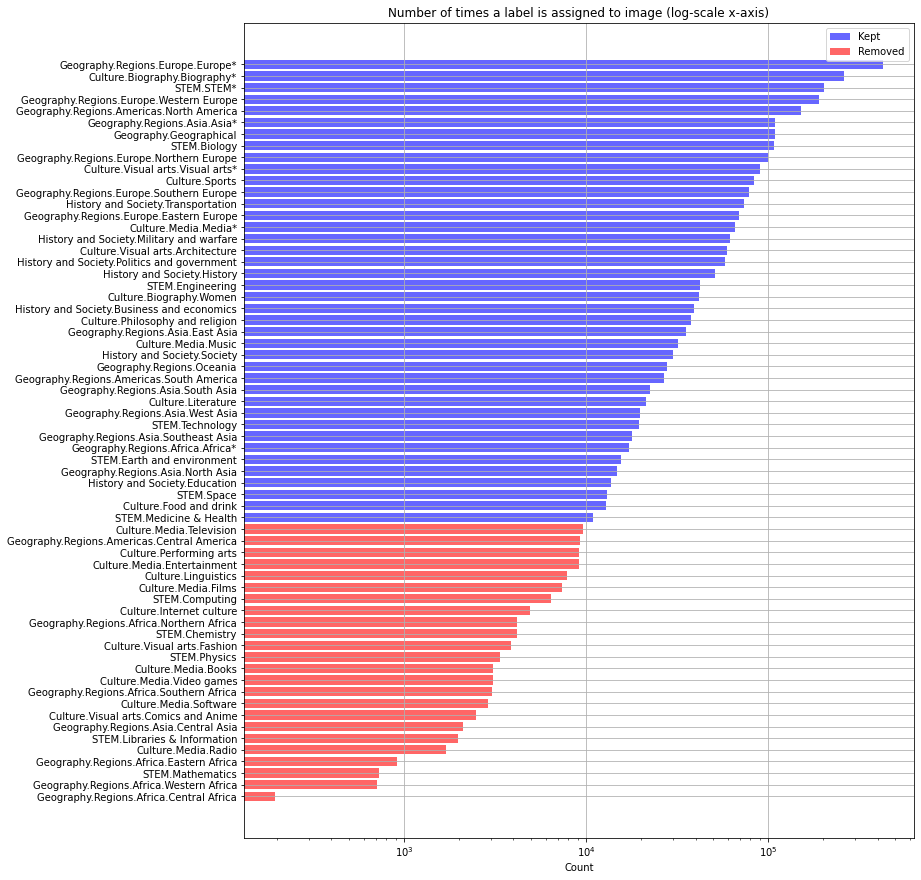

In [7]:
sorted_indices = np.argsort(np.sum(y_true, axis=0))
sorted_images_per_class = y_true.sum(axis=0)[sorted_indices]

mask_kept = y_true.sum(axis=0)[sorted_indices] > MINIMAL_NR_IMAGES
mask_removed = y_true.sum(axis=0)[sorted_indices] < MINIMAL_NR_IMAGES

_ = plt.figure(figsize=(12, 15))
_ = plt.title('Number of times a label is assigned to image (log-scale x-axis)')

_ = plt.barh(np.array(range(y_true.shape[1]))[mask_kept], sorted_images_per_class[mask_kept], color='blue', alpha=0.6)
_ = plt.barh(np.array(range(y_true.shape[1]))[mask_removed], sorted_images_per_class[mask_removed], color='red', alpha=0.6)

_ = plt.yticks(range(y_true.shape[1]), np.array(list(_data.class_indices.keys()))[sorted_indices])
_ = plt.xscale('log')
_ = plt.xlabel('Count')
_ = plt.grid(True)

plt.legend(['Kept', 'Removed'], loc='upper right')

In [8]:
indices_of_classes_to_remove = np.where(np.sum(y_true, axis=0) < MINIMAL_NR_IMAGES)
classes_to_remove = np.array(list(_data.class_indices.keys()))[indices_of_classes_to_remove] # JOB DONE!
print(f'Classes with less than {MINIMAL_NR_IMAGES} to remove: {classes_to_remove}')

Classes with less than 10000 to remove: ['Culture.Internet culture' 'Culture.Linguistics' 'Culture.Media.Books'
 'Culture.Media.Entertainment' 'Culture.Media.Films' 'Culture.Media.Radio'
 'Culture.Media.Software' 'Culture.Media.Television'
 'Culture.Media.Video games' 'Culture.Performing arts'
 'Culture.Visual arts.Comics and Anime' 'Culture.Visual arts.Fashion'
 'Geography.Regions.Africa.Central Africa'
 'Geography.Regions.Africa.Eastern Africa'
 'Geography.Regions.Africa.Northern Africa'
 'Geography.Regions.Africa.Southern Africa'
 'Geography.Regions.Africa.Western Africa'
 'Geography.Regions.Americas.Central America'
 'Geography.Regions.Asia.Central Asia' 'STEM.Chemistry' 'STEM.Computing'
 'STEM.Libraries & Information' 'STEM.Mathematics' 'STEM.Physics']


Now, remove these classes from the taxo_labels, and remove the images that were only belonging to these classes from the data dataframe.

In [9]:
data['taxo_labels'] = data['taxo_labels'].apply(lambda labels: [el for el in labels if el not in classes_to_remove])
data_clean = data[data.taxo_labels.str.len() != 0]
print(f'Removed {data.shape[0] - data_clean.shape[0]} images that were only labeled as the removed classes. Left with {data_clean.shape[0]/1e6:.2f} M images.')

Removed 19227 images that were only labeled as the removed classes. Left with 1.02 M images.


### 1. Separate data into training, validation and test sets

In [10]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(data_clean, test_size=0.1, random_state=17)
train_df, val_df = train_test_split(train_df, train_size=0.9, random_state=17)

Divide dataset into train and validation sets

In [11]:
# Data generator for training and validation sets, performs data augmentations
train_generator = ImageDataGenerator(validation_split=0.10, 
                                         rescale=1/255, # rescale inputs so that they are between 0 and 1, and not 0 and 255
                                         rotation_range=40,
                                         width_shift_range=0.2,
                                         height_shift_range=0.2,
                                         shear_range=0.2,
                                         zoom_range=0.2,
                                         horizontal_flip=True,
                                         fill_mode='nearest') 

print('\n----------- Train images -----------')
train = train_generator.flow_from_dataframe(dataframe=train_df, 
                                                directory='/scratch/WIT_Dataset/images', 
                                                x_col='image_path', 
                                                y_col='taxo_labels', 
                                                class_mode='categorical',
                                                subset='training',
                                                validate_filenames=True,
                                                target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION)) # the dimensions to which all images found will be resized.

print('\n----------- Validation images -----------')          
val = train_generator.flow_from_dataframe(dataframe=val_df, 
                                              directory='/scratch/WIT_Dataset/images', 
                                              x_col='image_path', 
                                              y_col='taxo_labels', 
                                              class_mode='categorical',
                                              subset='validation',
                                              validate_filenames=True,
                                              target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION))

# Data generator for test set
test_generator = ImageDataGenerator(rescale=1/255) 
print('\n----------- Test images -----------')          
test = test_generator.flow_from_dataframe(dataframe=test_df,
                                          directory='/scratch/WIT_Dataset/images',
                                          x_col='image_path', 
                                          y_col='taxo_labels', 
                                          class_mode='categorical',
                                          validate_filenames=True,
                                          target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION))


----------- Train images -----------


/home/matvieir/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 127841 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


Found 629370 validated image filenames belonging to 40 classes.

----------- Validation images -----------


/home/matvieir/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 14293 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


Found 7761 validated image filenames belonging to 40 classes.

----------- Test images -----------


/home/matvieir/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 15694 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


Found 86423 validated image filenames belonging to 40 classes.


In [20]:
test_df.to_json('data/test_df.json.bz2', compression='bz2')

In [22]:
import pickle

with open('pickles/test_set.pickle', 'wb') as f:
    pickle.dump(test, f)

TypeError: cannot pickle '_thread.lock' object

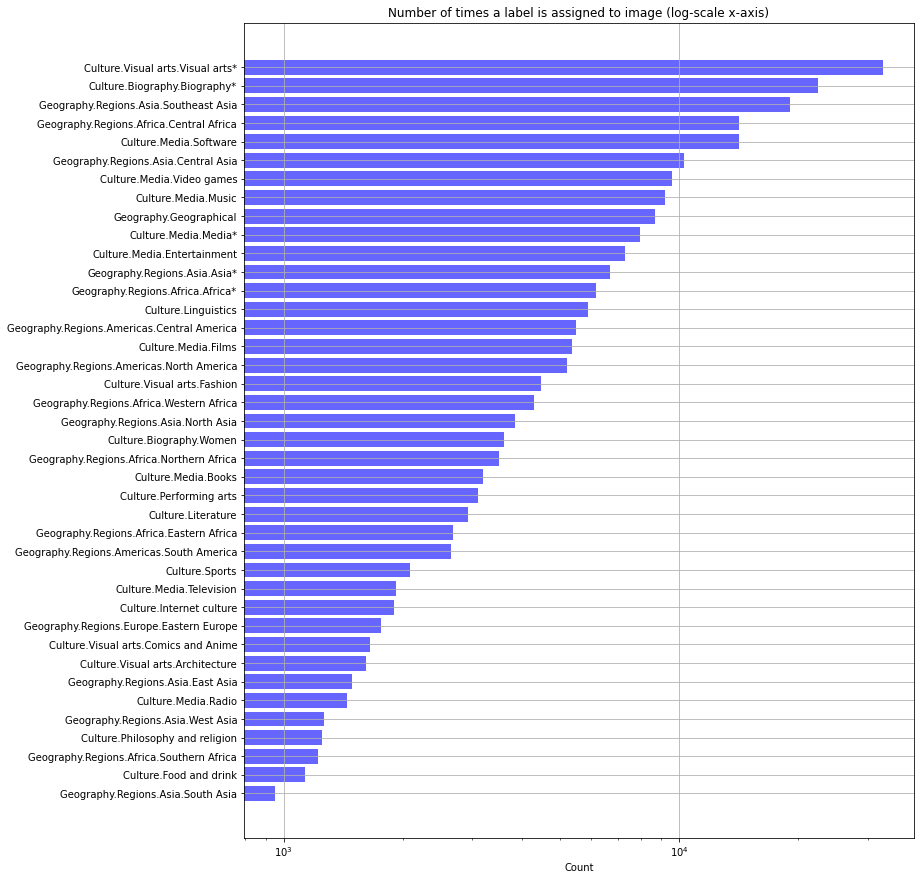

In [14]:
y_true_test = get_y_true(test.samples, test.class_indices, test.classes)

sorted_indices = np.argsort(np.sum(y_true_test, axis=0))
sorted_images_per_class = y_true_test.sum(axis=0)[sorted_indices]

# mask_kept = y_true.sum(axis=0)[sorted_indices] > MINIMAL_NR_IMAGES
# mask_removed = y_true.sum(axis=0)[sorted_indices] < MINIMAL_NR_IMAGES

_ = plt.figure(figsize=(12, 15))
_ = plt.title('Number of times a label is assigned to image (log-scale x-axis)')

_ = plt.barh(np.array(range(y_true_test.shape[1])), sorted_images_per_class, color='blue', alpha=0.6)
# _ = plt.barh(np.array(range(y_true.shape[1])), sorted_images_per_class, color='red', alpha=0.6)

_ = plt.yticks(range(y_true_test.shape[1]), np.array(list(_data.class_indices.keys()))[sorted_indices])
_ = plt.xscale('log')
_ = plt.xlabel('Count')
_ = plt.grid(True)

### 2. Construct and train model
Here, we construct a model where the first layers are EfficientNetB0 pre-trained on ImageNet-1k(https://keras.io/api/applications/efficientnet/) with added layers to the end, and train these final end layers with our training data.

In [15]:
from tensorflow.keras.applications import EfficientNetB0
from keras.models import Sequential
from keras.layers import Dense, Flatten

# Take efficientnet pre-trained on imagenet-1k, not including the last layer 
N_CLASSES = len(train.class_indices)
efficient_net = EfficientNetB0(include_top=False, 
                               weights='imagenet', 
                               input_shape=(IMAGE_DIMENSION, IMAGE_DIMENSION, 3), # to be specified if include_top is False.
                               classes=N_CLASSES)
efficient_net.trainable = False

In [16]:
# Add a final layer with the same number of neurons as there are classes and train only weights of this layer, i.e. transfer learning!
model = Sequential()
model.add(efficient_net)
model.add(Flatten())
model.add(Dense(units=120, activation='relu'))
model.add(Dense(units=N_CLASSES, activation='sigmoid')) # output layer

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 2, 2, 1280)       4049571   
                                                                 
 flatten (Flatten)           (None, 5120)              0         
                                                                 
 dense (Dense)               (None, 120)               614520    
                                                                 
 dense_1 (Dense)             (None, 40)                4840      
                                                                 
Total params: 4,668,931
Trainable params: 619,360
Non-trainable params: 4,049,571
_________________________________________________________________


Compile model

In [17]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', # on what loss function to choose: https://stats.stackexchange.com/questions/260505/should-i-use-a-categorical-cross-entropy-or-binary-cross-entropy-loss-for-binary
              metrics=['accuracy']) 

Train model

In [12]:
y_true = get_y_true(train.samples, train.class_indices, train.classes)

def compute_class_weights(y_true):
    """
    Computes class_weights to compensate imbalanced classes. Inspired in 
    'https://towardsdatascience.com/dealing-with-imbalanced-data-in-tensorflow-class-weights-60f876911f99'.
    Dictionary mapping class indices (integers) to a weight (float) value, 
    used for weighting the loss function (during training only).
    """
    class_count = y_true.sum(axis=0)
    n_samples = y_true.shape[0] 
    n_classes = y_true.shape[1]

    # Compute class weights using balanced method
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights))
    return dict(zip(class_labels, class_weights))

class_weights = compute_class_weights(y_true)#dict(enumerate(y_true.sum().sum() / y_true.sum(axis=0)))
print(class_weights)

{0: 0.09568383604962297, 1: 0.5917801263727998, 2: 1.8931837324028395, 3: 1.1577814569536424, 4: 0.36230657640232106, 5: 0.7459465225430237, 6: 0.6542035674192341, 7: 0.2957899387148927, 8: 0.3967384452457198, 9: 0.266569250317662, 10: 0.23854229836264404, 11: 1.4494933210502072, 12: 0.15228658536585366, 13: 1.1348997403346797, 14: 0.22676404461995214, 15: 0.7013260530421217, 16: 1.8010817307692308, 17: 1.0223684210526316, 18: 1.3442332336608287, 19: 1.321539559885772, 20: 0.5000397254179114, 21: 0.06560475161987041, 22: 0.2502107054258635, 23: 0.35357865168539326, 24: 0.14934223639625274, 25: 0.7909042927515834, 26: 0.6094766811279827, 27: 1.7091299152726482, 28: 0.48917301414581066, 29: 0.39790228359001595, 30: 0.41428815924589907, 31: 0.818213728549142, 32: 0.3195679990251036, 33: 0.21122917477748393, 34: 1.51875, 35: 0.5571026449031619, 36: 2.2305429543521407, 37: 0.11392384441612605, 38: 1.7714760189146588, 39: 1.2567292332268372}


In [18]:
EPOCHS = 50
history = model.fit(train, 
                    epochs=EPOCHS, 
                    steps_per_epoch=15, 
                    validation_data=val,
                    validation_steps=7,verbose=2)
                    # class_weight=class_weights)

Epoch 1/50
15/15 - 44s - loss: 0.5489 - accuracy: 0.0417 - val_loss: 0.4474 - val_accuracy: 0.0580 - 44s/epoch - 3s/step
Epoch 2/50
15/15 - 10s - loss: 0.4048 - accuracy: 0.0375 - val_loss: 0.3733 - val_accuracy: 0.0580 - 10s/epoch - 678ms/step
Epoch 3/50
15/15 - 10s - loss: 0.3510 - accuracy: 0.0479 - val_loss: 0.3251 - val_accuracy: 0.0580 - 10s/epoch - 655ms/step
Epoch 4/50
15/15 - 10s - loss: 0.2990 - accuracy: 0.0479 - val_loss: 0.2730 - val_accuracy: 0.0625 - 10s/epoch - 644ms/step
Epoch 5/50
15/15 - 11s - loss: 0.2730 - accuracy: 0.0479 - val_loss: 0.2508 - val_accuracy: 0.0402 - 11s/epoch - 729ms/step
Epoch 6/50


/home/matvieir/anaconda3/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


15/15 - 10s - loss: 0.2468 - accuracy: 0.1187 - val_loss: 0.2447 - val_accuracy: 0.1473 - 10s/epoch - 654ms/step
Epoch 7/50
15/15 - 10s - loss: 0.2475 - accuracy: 0.1729 - val_loss: 0.2348 - val_accuracy: 0.2277 - 10s/epoch - 656ms/step
Epoch 8/50
15/15 - 11s - loss: 0.2366 - accuracy: 0.1542 - val_loss: 0.2328 - val_accuracy: 0.1920 - 11s/epoch - 704ms/step
Epoch 9/50
15/15 - 11s - loss: 0.2339 - accuracy: 0.1729 - val_loss: 0.2333 - val_accuracy: 0.1830 - 11s/epoch - 741ms/step
Epoch 10/50
15/15 - 11s - loss: 0.2272 - accuracy: 0.1500 - val_loss: 0.2238 - val_accuracy: 0.1964 - 11s/epoch - 764ms/step
Epoch 11/50
15/15 - 11s - loss: 0.2324 - accuracy: 0.1708 - val_loss: 0.2234 - val_accuracy: 0.1830 - 11s/epoch - 749ms/step
Epoch 12/50
15/15 - 11s - loss: 0.2264 - accuracy: 0.1500 - val_loss: 0.2247 - val_accuracy: 0.1473 - 11s/epoch - 740ms/step
Epoch 13/50
15/15 - 11s - loss: 0.2201 - accuracy: 0.1542 - val_loss: 0.2348 - val_accuracy: 0.1607 - 11s/epoch - 711ms/step
Epoch 14/50
15/

Plot training vs validation accuracy and loss

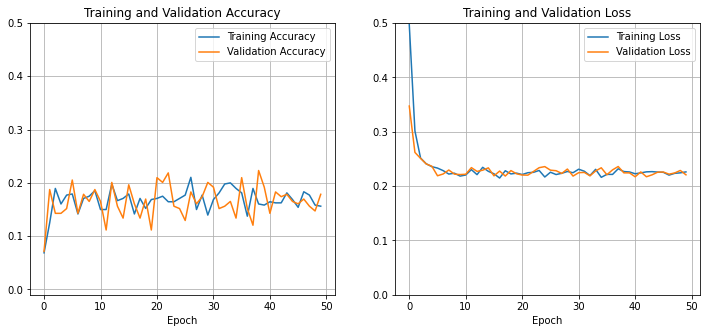

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

EPOCHS = 50

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.xlabel('Epoch')
plt.ylim(-0.01, 0.5)
plt.grid(True)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.xlabel('Epoch')
plt.ylim(0, 0.5)
plt.grid(True)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 3. Evaluation metrics
Here, we evaluate the trained model on the test set and take out classification metrics (precision & recall) for each of the individual 64 classes.

In [21]:
test_accuracy_score = model.evaluate(test, verbose=0)
print(test_accuracy_score)
print("Accuracy: {:.4f}%".format(test_accuracy_score[1] * 100)) 
print("Loss: ", test_accuracy_score[0])

KeyboardInterrupt: 

In [ ]:
predictions = model.predict(test)
print(predictions.shape)
threshold = 0.1
y_pred = 1 * (predictions > threshold)

In [ ]:
# Transform 'test.classes' to a one-hot encoded matrix, y_true
y_true = np.zeros(y_pred.shape)
for row_idx, row in enumerate(test.classes):
    for idx in row:
        y_true[row_idx, idx] = 1

Make predictions on the test set and then get classification metrics

In [ ]:
from sklearn.metrics import classification_report

metrics_df = pd.DataFrame(classification_report(y_true, y_pred, target_names=list(test.class_indices), output_dict=True)).transpose()
metrics_df['index'] = np.concatenate((np.arange(start=0, stop=N_CLASSES), [None, None, None, None]))
metrics_df.tail(4)

Precision & recall metrics for each class

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(18,3))
axs[0].set_xlabel('Label')
axs[0].set_ylabel('Precision')
axs[0].set_title('Precision')
axs[1].set_xlabel('Label')
axs[1].set_ylabel('Recall')
axs[1].set_title('Recall')
axs[0].set_ylim([-0.05, 1.05])
axs[1].set_ylim([-0.05, 1.05])
axs[0].set_xticks(range(y_true.shape[1]), range(y_true.shape[1]))
axs[1].set_xticks(range(y_true.shape[1]), range(y_true.shape[1]))
axs[0].plot(range(y_true.shape[1]), metrics_df.precision[0:40], 'bo')
axs[1].plot(range(y_true.shape[1]), metrics_df.recall[0:40], 'bo')